$$\Huge\textbf{Image Classification with CNN}$$

# Imports

In [1]:
# standard library imports
import os  # Directory and file operations

# installed library imports
import matplotlib.pyplot as plt  # Plotting library
import numpy as np
import torch  # PyTorch main library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torchsummary import summary  # Model summary utility
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as transforms  # Transformations for image preprocessing
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import DataLoader  # Data loading utilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc  # Performance metrics

# Global Constants

In [2]:
# Directories
RAW_DATA_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\raw_data'
RAW_TRAIN_VAL_DIR = os.path.join(RAW_DATA_DIR, 'train_val')
RAW_TEST_DIR = os.path.join(RAW_DATA_DIR, 'test')

# Constants
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
NUM_CLASSES = 5
CLASSES = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']
TRAIN_SPLIT = 0.8235


# 1. Data Loading and Preprocessing

In [3]:
def get_data_loaders(train_val_dir, test_dir, batch_size=BATCH_SIZE, train_split=TRAIN_SPLIT):
    """
    Create data loaders for training, validation, and testing.

    Inputs:
    - train_val_dir (str): Path to the training and validation data directory.
    - test_dir (str): Path to the test data directory.
    - batch_size (int): Batch size for the data loaders.
    - train_split (float): Proportion of data to use for training.

    Outputs:
    - train_loader, val_loader, test_loader (DataLoader): Data loaders for training, validation, and testing.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize tensor to range [-1, 1]
    ])
    
    # Load datasets with ImageFolder
    train_val_dataset = datasets.ImageFolder(root=train_val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # Split train_val_dataset into train and validation datasets
    train_size = int(train_split * len(train_val_dataset))  # Adjust based on the split ratio
    val_size = len(train_val_dataset) - train_size

    train_dataset, val_dataset = data.random_split(train_val_dataset, [train_size, val_size])

    # Create DataLoaders for each dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# 2. Model Initialization

## 2.1. Weight Initialization

In [4]:
def weights_init(m):
    """
    Initialize weights with a Gaussian distribution.

    Inputs:
    - m (nn.Module): A neural network module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # He initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)  # Initialize bias to 0

## 2.2. CNN Architecture

In [5]:
"""
CNN Architecture:
- Conv Layer 1: 3 input channels, 32 output channels, kernel size 3x3, stride 1, padding 1
- BatchNorm Layer 1: 32 channels
- ReLU Activation 1
- MaxPool Layer 1: kernel size 2x2, stride 2
- Conv Layer 2: 32 input channels, 64 output channels, kernel size 3x3, stride 1, padding 1
- BatchNorm Layer 2: 64 channels
- ReLU Activation 2
- MaxPool Layer 2: kernel size 2x2, stride 2
- Conv Layer 3: 64 input channels, 128 output channels, kernel size 3x3, stride 1, padding 1
- BatchNorm Layer 3: 128 channels
- ReLU Activation 3
- MaxPool Layer 3: kernel size 2x2, stride 2
- Dropout: 0.5
- Fully Connected Layer 1: 128 * 32 * 32 inputs, 512 outputs
- ReLU Activation 4
- Dropout: 0.5
- Fully Connected Layer 2: 512 inputs, 5 class outputs
"""

'\nCNN Architecture:\n- Conv Layer 1: 3 input channels, 32 output channels, kernel size 3x3, stride 1, padding 1\n- BatchNorm Layer 1: 32 channels\n- ReLU Activation 1\n- MaxPool Layer 1: kernel size 2x2, stride 2\n- Conv Layer 2: 32 input channels, 64 output channels, kernel size 3x3, stride 1, padding 1\n- BatchNorm Layer 2: 64 channels\n- ReLU Activation 2\n- MaxPool Layer 2: kernel size 2x2, stride 2\n- Conv Layer 3: 64 input channels, 128 output channels, kernel size 3x3, stride 1, padding 1\n- BatchNorm Layer 3: 128 channels\n- ReLU Activation 3\n- MaxPool Layer 3: kernel size 2x2, stride 2\n- Dropout: 0.5\n- Fully Connected Layer 1: 128 * 32 * 32 inputs, 512 outputs\n- ReLU Activation 4\n- Dropout: 0.5\n- Fully Connected Layer 2: 512 inputs, 5 class outputs\n'

In [6]:
class CNN(nn.Module):
    """
    A simple Convolutional Neural Network for image classification.
    """
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Third convolutional layer
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Dropout(0.5)  # Dropout for regularization
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 32 * 32, 512),  # Fully connected layer
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, num_classes)  # Output layer
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Inputs:
        - x (Tensor): Input image tensor.

        Outputs:
        - x (Tensor): Output logits tensor.
        """
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


# 3. Model Training

In [7]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """
    Train the CNN model.

    Inputs:
    - model (nn.Module): The CNN model.
    - criterion (nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - num_epochs (int): Number of epochs to train the model.

    Outputs:
    - model (nn.Module): The trained CNN model.
    - history (dict): Dictionary containing training and validation loss and accuracy for each epoch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}')
    
    return model, history


# 4. Model Evaluation

## 4.1. Performances of the Results

In [8]:
def evaluate_model(model, data_loader, dataset_type="Test"):
    """
    Evaluate the CNN model on a dataset.

    Inputs:
    - model (nn.Module): The CNN model.
    - data_loader (DataLoader): DataLoader for the data.
    - dataset_type (str): Type of the dataset (Train/Validation/Test).

    Outputs:
    - accuracy (float): Accuracy of the model on the dataset.
    - precision (float): Precision of the model on the dataset.
    - recall (float): Recall of the model on the dataset.
    - f1 (float): F1 score of the model on the dataset.
    - cm (ndarray): Confusion matrix of the model on the dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f'{dataset_type} Accuracy: {accuracy:.2f}')
    print(f'{dataset_type} Precision: {precision:.2f}')
    print(f'{dataset_type} Recall: {recall:.2f}')
    print(f'{dataset_type} F1-Score: {f1:.2f}')
    print(f'{dataset_type} Confusion Matrix:')
    print(cm)

    return accuracy, precision, recall, f1, cm

## 4.2. Performances Over the Epochs

In [9]:
def plot_metrics(history):
    """
    Plot training and validation loss and accuracy over epochs.

    Inputs:
    - history (dict): Dictionary containing training and validation loss and accuracy for each epoch.
    """
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [10]:
def plot_roc_auc(model, data_loader, num_classes=NUM_CLASSES):
    """
    Plot ROC curve and calculate AUC for each class.

    Inputs:
    - model (nn.Module): The trained CNN model.
    - data_loader (DataLoader): DataLoader for the data.
    - num_classes (int): Number of classes.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()


# 4. Main Execution

In [22]:
# Create data loaders
train_loader, val_loader, test_loader = get_data_loaders(RAW_TRAIN_VAL_DIR, RAW_TEST_DIR, BATCH_SIZE, TRAIN_SPLIT)

# Initialize model
model = CNN(num_classes=NUM_CLASSES)

# Print the architecture of the CNN
#summary(model, input_size=(3, 256, 256))

In [14]:
# Initialize the weights
model.apply(weights_init)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
# Train the model and collect training history
trained_model, history = train_model(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS)

Epoch 0/24, Train Loss: 13.5218, Train Accuracy: 50.93, Val Loss: 0.9807, Val Accuracy: 66.84
Epoch 1/24, Train Loss: 1.1397, Train Accuracy: 53.56, Val Loss: 0.9878, Val Accuracy: 65.78
Epoch 2/24, Train Loss: 1.0998, Train Accuracy: 56.04, Val Loss: 0.8451, Val Accuracy: 65.91
Epoch 3/24, Train Loss: 1.0953, Train Accuracy: 53.62, Val Loss: 0.8992, Val Accuracy: 64.98
Epoch 4/24, Train Loss: 1.0763, Train Accuracy: 56.93, Val Loss: 0.8179, Val Accuracy: 67.24
Epoch 5/24, Train Loss: 1.0217, Train Accuracy: 58.53, Val Loss: 0.8420, Val Accuracy: 64.18
Epoch 6/24, Train Loss: 0.9533, Train Accuracy: 59.65, Val Loss: 0.7883, Val Accuracy: 69.11
Epoch 7/24, Train Loss: 0.9963, Train Accuracy: 58.76, Val Loss: 0.8298, Val Accuracy: 68.18
Epoch 8/24, Train Loss: 0.9374, Train Accuracy: 61.10, Val Loss: 0.8501, Val Accuracy: 67.91
Epoch 9/24, Train Loss: 0.9183, Train Accuracy: 60.67, Val Loss: 0.7873, Val Accuracy: 70.71
Epoch 10/24, Train Loss: 0.8717, Train Accuracy: 64.10, Val Loss: 0.8

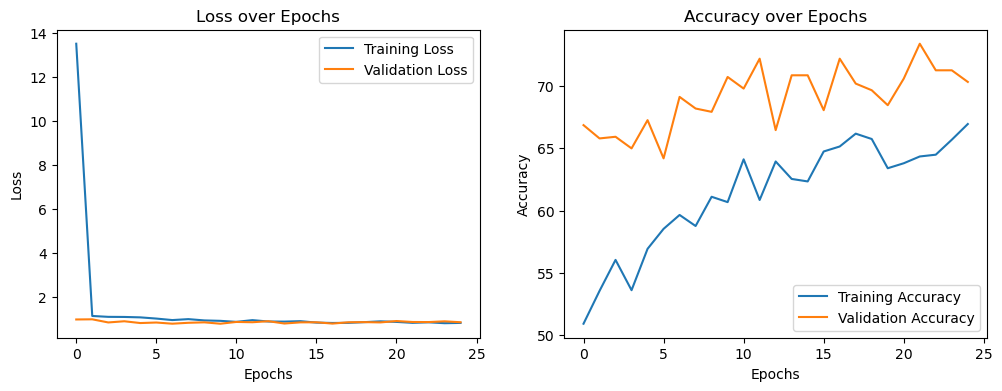

In [16]:
# Plot training and validation metrics
plot_metrics(history)

In [17]:
# Evaluate the model on the training set
print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1, train_cm = evaluate_model(trained_model, train_loader, dataset_type="Train")


Training Set Evaluation:
Train Accuracy: 0.83
Train Precision: 0.83
Train Recall: 0.83
Train F1-Score: 0.83
Train Confusion Matrix:
[[521   0  75 105   4]
 [  0 660   2  42   0]
 [  0   0 681  26   0]
 [ 83   5  65 434 106]
 [  9   1   2  56 622]]


In [18]:
# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(trained_model, val_loader, dataset_type="Validation")


Validation Set Evaluation:
Validation Accuracy: 0.70
Validation Precision: 0.71
Validation Recall: 0.70
Validation F1-Score: 0.70
Validation Confusion Matrix:
[[ 80   2  22  34   7]
 [  0 132   3  11   0]
 [  4   2 123  14   0]
 [ 18   8  19  73  39]
 [  1   4   3  32 120]]


In [19]:
# Evaluate the model on the test set
print("\nTest Set Evaluation:")
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(trained_model, test_loader, dataset_type="Test")


Test Set Evaluation:
Test Accuracy: 0.69
Test Precision: 0.70
Test Recall: 0.69
Test F1-Score: 0.69
Test Confusion Matrix:
[[ 80   4  21  32  13]
 [  1 129   2  13   5]
 [  3   2 126  17   2]
 [ 15  12  21  72  30]
 [  5   4   4  25 112]]


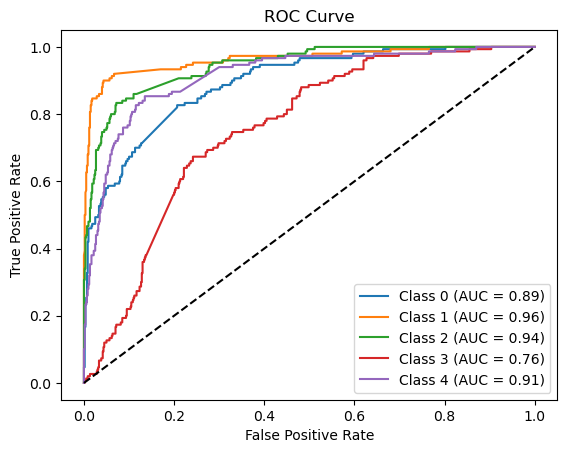

In [20]:
# Plot ROC and AUC for the test set
plot_roc_auc(trained_model, test_loader, num_classes=NUM_CLASSES)